In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
from skimage import io
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
from keras import models, layers
from keras import losses, optimizers, metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K
from keras.utils import multi_gpu_model
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from skimage.morphology import label
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

data_folder = Path('/home/yuyuliao/ninja_project/data/airbus/')

os.listdir(str(data_folder))

Using TensorFlow backend.


_pywrap_tensorflow_internal /usr/local/lib/python3.5/dist-packages/tensorflow/python/_pywrap_tensorflow_internal.so


['train_ship_segmentations_v2.csv',
 'sample_submission_v2.csv',
 'test_v2.zip',
 'train',
 'train_v2.zip',
 'train_ship_segmentations_v2.csv.zip',
 'test']

In [2]:
masks = pd.read_csv(str(data_folder / 'train_ship_segmentations_v2.csv'))
train_path = data_folder / 'train'
test_path = data_folder / 'test'
train_images_list = os.listdir(str(train_path))
test_images_list = os.listdir(str(test_path))

In [3]:
masks = masks[masks['ImageId'] != '6384c3e78.jpg']

In [4]:
masks['ships'] = masks['EncodedPixels'].map(lambda row: 1 if isinstance(row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x > 0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])


In [5]:
unique_img_ids.shape, masks.shape

((192555, 4), (231722, 3))

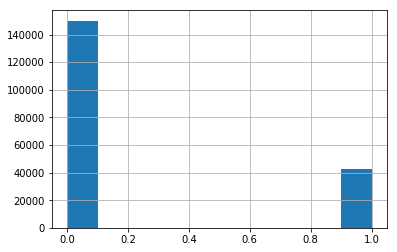

In [6]:
unique_img_ids['has_ship'].hist()

In [7]:
unique_img_ids['has_ship'].value_counts()

0.0    149999
1.0     42556
Name: has_ship, dtype: int64

In [9]:
#num_has_ship = unique_img_ids['has_ship'].value_counts()[1]
#no_ship_ids = unique_img_ids[unique_img_ids['has_ship'] == 0].sample(num_has_ship,
#                                                                     random_state=202109)

num_of_has_ship = 15000
num_of_no_ship = 10000
has_ship_df = unique_img_ids[unique_img_ids['has_ship'] == 1].sample(num_of_has_ship)
no_ship_df = unique_img_ids[unique_img_ids['has_ship'] == 0].sample(num_of_no_ship)

In [10]:
concat_data = pd.concat([has_ship_df, no_ship_df],  axis=0)
concat_data.shape


(25000, 4)

In [11]:
%%time
import multiprocessing
import collections
from PIL import Image
import gc

def image_to_array(_train_path, _img, _ship):
    image_array = Image.open(str(_train_path / _img)).resize((256,256)).convert('RGB')
    return _img, image_array, _ship

pool_size = multiprocessing.cpu_count()
pool = multiprocessing.Pool(processes=pool_size)
result = []

for i, img in enumerate(concat_data['ImageId']):    
    result.append(pool.apply_async(image_to_array, 
                                   args=(train_path, img, concat_data.iloc[i, 2], )))
pool.close()
pool.join()

get_process_result = []
for res in result:
    get_process_result.append(res.get(10))
    
gc.collect()

CPU times: user 11.2 s, sys: 7.21 s, total: 18.4 s
Wall time: 3min 12s


In [12]:
%%time
training_img_data = []
target_data = []

data_img_array = np.empty((len(concat_data['ImageId']), 256, 256,3), dtype=np.uint8)
data_target = np.empty((len(concat_data['ImageId'])), dtype=np.uint8)

for i, line in enumerate(get_process_result):
    data_img_array[i] = line[1]
    data_target[i] = line[2]

CPU times: user 3.33 s, sys: 2.2 s, total: 5.53 s
Wall time: 5.52 s


In [13]:
del result, get_process_result

In [16]:
from sklearn.preprocessing import OneHotEncoder
targets =data_target.reshape(len(data_target),-1)
enc = OneHotEncoder()
enc.fit(targets)
targets = enc.transform(targets).toarray()
print(targets.shape)

(25000, 2)


In [17]:
collections.Counter(data_target)

Counter({0: 10000, 1: 15000})

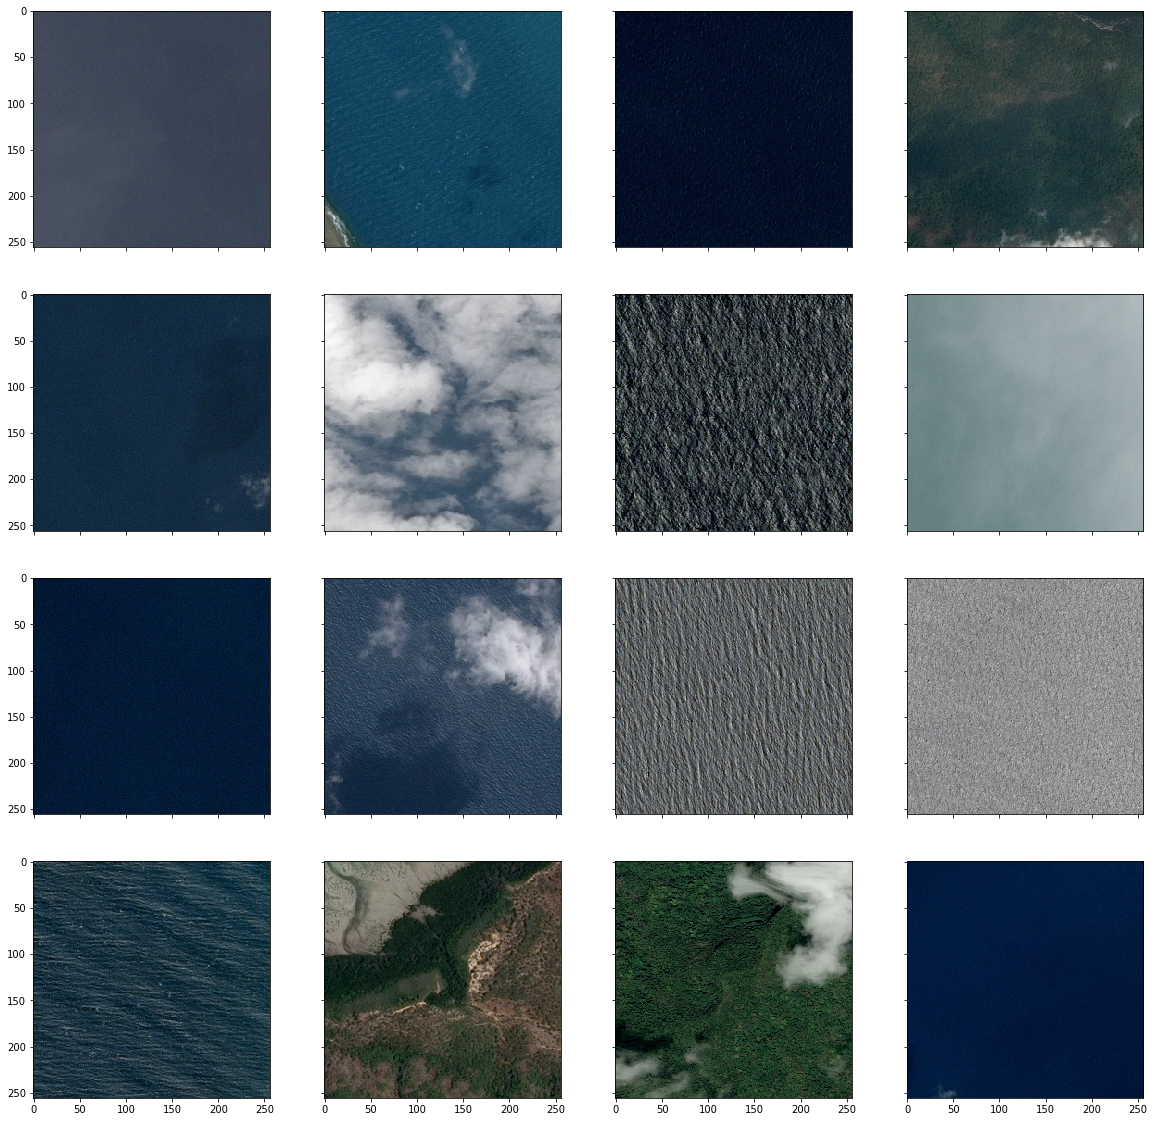

In [28]:
fig, ax = plt.subplots(4, 4, sharex='col', sharey='row')
fig.set_size_inches(20, 20)
for i, imgid in enumerate(data_img_array[0:16]):
    col = i % 4
    row = i // 4
    img = Image.fromarray(data_img_array[i], 'RGB')
    ax[row, col].imshow(img)  

#check_img = Image.fromarray(data_img_array[5], 'RGB')
#check_img

In [18]:
train_x, valid_x, train_y, valid_y = train_test_split(data_img_array, 
                                                      targets, 
                                                      test_size=0.2)


In [17]:
'''
import math
index_list = list(range(len(data_target)))
train_index = np.random.choice(index_list, size=math.floor(len(data_target) * 0.7))
train_x = data_img_array[train_index]
train_y = data_target[train_index]
valid_x = data_img_array[-train_index]
valud_y = data_target[-train_index]
'''

In [19]:
img_gen = ImageDataGenerator(
    rescale=1./255,
    zca_whitening = False,
    rotation_range = 90,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    brightness_range = [0.5, 1.5],
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True
)

In [20]:
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16

model_name = 'resnet50'
IMG_WIDTH, IMG_HIGHT, CHANNELS = 256, 256, 3
if model_name == 'resnet50':
    model = ResNet50(weights='imagenet', 
                     include_top=False, 
                     input_shape=(IMG_WIDTH, IMG_HIGHT, CHANNELS))
elif model_name == 'vgg':
    model = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(IMG_WIDTH, IMG_HIGHT, CHANNELS))
else:
    raise ValueError



In [21]:
def get_bn_params(**params):
    default_bn_params = {
        'axis': -1,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True
    }
    default_bn_params.update(params)
    return default_bn_params

no_scale_bn_params = get_bn_params(scale=False)
no_scale_bn_params

{'axis': -1,
 'center': True,
 'epsilon': 2e-05,
 'momentum': 0.99,
 'scale': False}

In [22]:
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Sequential, Model 
from keras.layers.normalization import BatchNormalization

for layer in model.layers:
    layer.trainable = False


x = model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization(**no_scale_bn_params)(x)
x = Dropout(0.33)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization(**no_scale_bn_params)(x)
x = Dropout(0.33)(x)
y = Dense(2, activation='softmax', name='Output')(x)

model_final = Model(input=model.input, output=y)


In [23]:
model_final.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [28]:
NUM_BATCH_SIZE = 32
NUM_STEPS = train_x.shape[0] / NUM_BATCH_SIZE
EPOCHS = 100
LEARNING_RATE = 0.01
DECAY_FACTOR = 0.96

In [34]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=DECAY_FACTOR, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001,
                              mode='min', 
                              cooldown=2, 
                              min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', 
                               mode='min', 
                               patience=15)

callbacks_list = [early_stopping, reduce_lr]


In [35]:
from keras.utils import multi_gpu_model
sgd = optimizers.SGD(lr=LEARNING_RATE, 
                     momentum=0.9,
                     decay=DECAY_FACTOR,
                     nesterov=False)
adam = optimizers.Adam(1e-4, decay=1e-6)

isMultiGPU = True
if isMultiGPU:
    parallel_model = multi_gpu_model(model_final, 2)
    parallel_model.compile(loss='categorical_crossentropy',
                           optimizer=adam,
                           metrics=[metrics.categorical_accuracy])
else:
    parallel_model = multi_gpu_model(model_final, 1)
    parallel_model.compile(loss='categorical_crossentropy',
                           optimizer=adam,
                           metrics=[metrics.categorical_accuracy])

In [ ]:
loss_history = [parallel_model.fit_generator(img_gen.flow(train_x, train_y, batch_size=NUM_BATCH_SIZE), 
                                             steps_per_epoch=NUM_STEPS,
                                             epochs=EPOCHS,
                                             validation_data=(valid_x, valid_y),
                                             callbacks=callbacks_list,
                                             shuffle=True,
                                             use_multiprocessing=False,
                                             workers=1)]

Epoch 1/100
625/625 [==============================] - 391s 626ms/step - loss: 0.5870 - categorical_accuracy: 0.7724 - val_loss: 0.5344 - val_categorical_accuracy: 0.7968
Epoch 2/100
625/625 [==============================] - 379s 606ms/step - loss: 0.4830 - categorical_accuracy: 0.8012 - val_loss: 0.6059 - val_categorical_accuracy: 0.8040
Epoch 3/100
625/625 [==============================] - 379s 606ms/step - loss: 0.4354 - categorical_accuracy: 0.8163 - val_loss: 0.5560 - val_categorical_accuracy: 0.8248
Epoch 4/100
515/625 [=======================>......] - ETA: 59s - loss: 0.4189 - categorical_accuracy: 0.8196

In [43]:
gc.collect()

0

In [44]:
num_of_test_data = 5000
test_data = unique_img_ids.sample(num_of_test_data)

In [45]:
%%time
from tqdm import tqdm
import collections
from PIL import Image
training_img_data = []
target_data = []
test_data_img_array = np.empty((len(test_data['ImageId']), 256, 256,3), dtype=np.uint8)
y_true = np.empty((len(test_data['ImageId'])), dtype=np.uint8)

for i, img in tqdm(enumerate(test_data['ImageId'])):
    image_array = Image.open(str(train_path / img)).resize((256,256)).convert('RGB')
    test_data_img_array[i] = image_array
    y_true[i] = test_data.iloc[i, 2]

5000it [05:25, 16.16it/s]

CPU times: user 1min 45s, sys: 1.75 s, total: 1min 47s
Wall time: 5min 25s


In [46]:
result = parallel_model.predict(test_data_img_array)
y_pred = np.argmax(result, axis=1)

In [47]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
C = confusion_matrix(y_true, y_pred)
C

array([[3717,  183],
       [ 304,  796]])

In [48]:
print('Accuracy: {}\nRecall: {}\nPrecision: {}'.format(accuracy_score(y_true, y_pred), 
                                                       recall_score(y_true, y_pred), 
                                                       precision_score(y_true, y_pred)))

Accuracy: 0.9026
Recall: 0.7236363636363636
Precision: 0.8130745658835546


# Predict testing data

In [49]:
%%time
testing_img_array = np.empty((len(test_images_list), 256, 256,3), dtype=np.uint8)
for i, f in tqdm(enumerate(test_images_list)):
    image_array = Image.open(str(test_path / f)).resize((256,256)).convert('RGB') 
    testing_img_array[i] = image_array
    

15606it [14:44, 17.64it/s]

CPU times: user 5min 29s, sys: 3.89 s, total: 5min 33s
Wall time: 14min 44s


In [50]:
testing_img_array.shape

(15606, 256, 256, 3)

In [51]:
testing_result = parallel_model.predict(testing_img_array)
testing_y_pred = np.argmax(testing_result, axis=1)

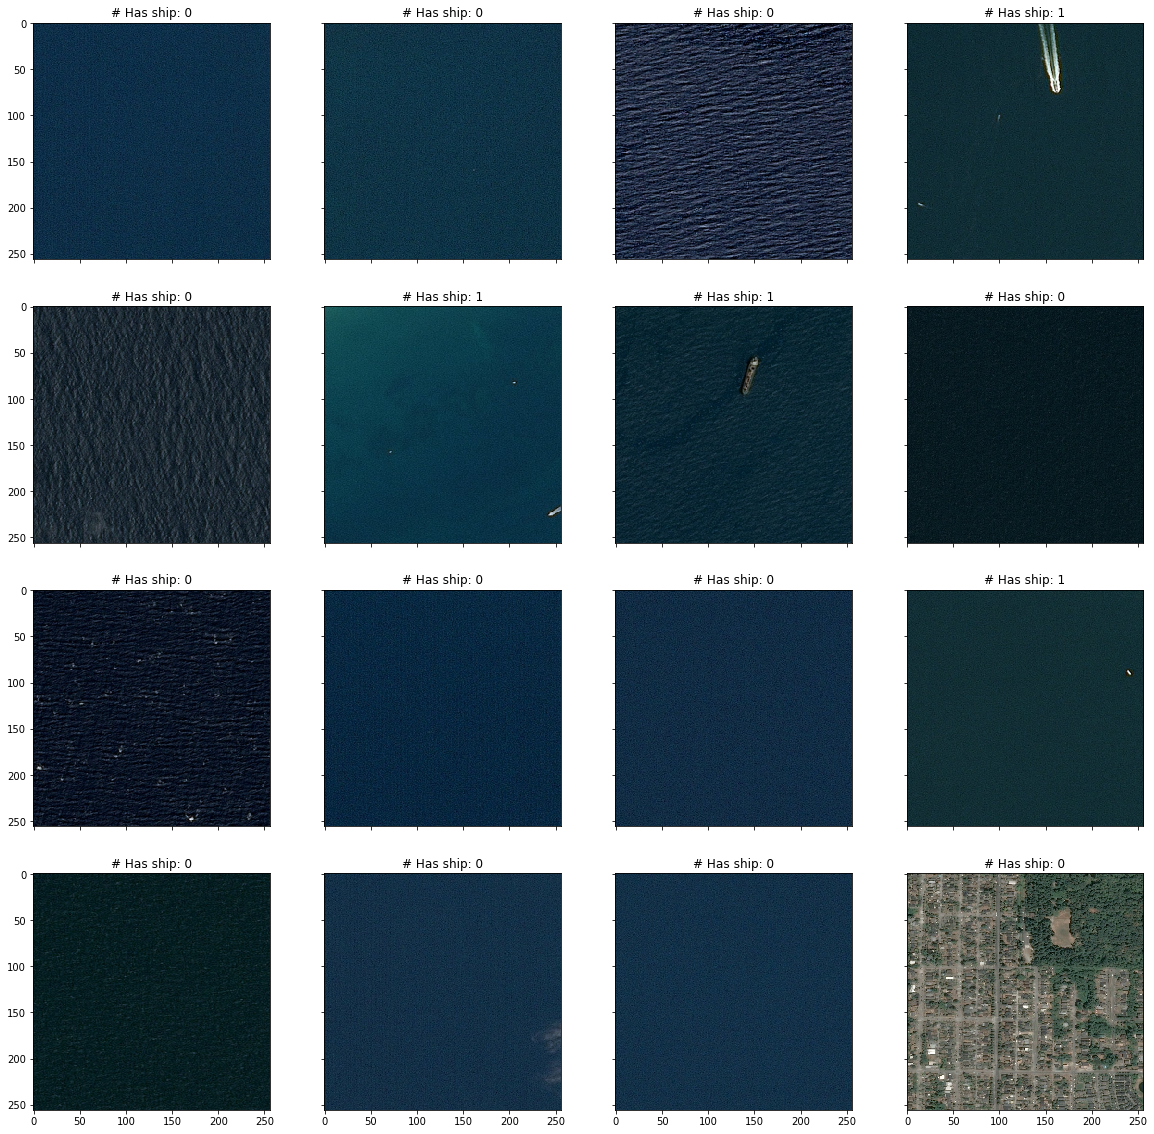

In [116]:
fig, ax = plt.subplots(4, 4, sharex='col', sharey='row')
fig.set_size_inches(20, 20)
for i, imgid in enumerate(testing_img_array[0:16]):
    col = i % 4
    row = i // 4
    img = Image.fromarray(testing_img_array[i], 'RGB')
    ax[row, col].imshow(img)  
    ax[row, col].set_title('# Has ship: {}'.format(testing_y_pred[i]))

#check_img = Image.fromarray(data_img_array[5], 'RGB')
#check_img

In [52]:
final_df = pd.DataFrame(list(zip(test_images_list, testing_y_pred.tolist())), columns=['ImageId', 'has_ship'])
final_df.to_csv('./has_ship_data.csv', index=False, header=True)
